# Self-Driving Car Engineering
## Vehicle Detection and Tracking
A pipeline to detect and track cars in a video stream from an autonomous car's forward facing camera

## Step 1: Build and train a classifier to detect cars in an image

In [68]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog

# Extract the image names
cars = glob.glob("./vehicles/*.png")
notcars = glob.glob("./non-vehicles/*.png")

#### Define a few functions to extract HOG features from a list of images

In [72]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img,
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


...


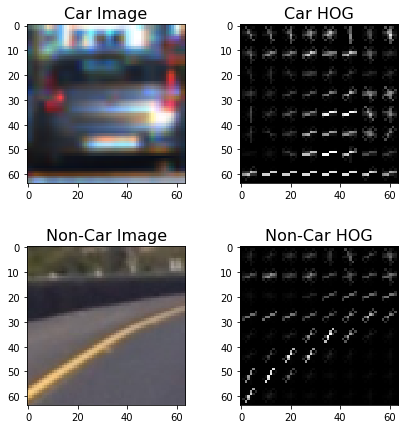

In [73]:
### REMOVE ______________________________________________________


car_img = mpimg.imread(cars[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(notcars[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

#### Extract all car and non-car features into their respective lists

In [74]:
import time

# define a few parameters for HOG feature extraction
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# extract HOG features
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

print(round(time.time()-t, 2), 'Seconds to extract HOG features...')


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


46.81 Seconds to extract HOG features...


#### Set up to train the classifier

In [82]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Randomly split up data into training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
  
# Don't need to scale if not using spatial binning and color histogram
# # Fit a per-column scaler
# scaler = StandardScaler().fit(X_train)
# # Apply the scaler to X
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print(X_train.shape)

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
(14208, 1188)


#### Use Grid Search to automatically fit the classifer with the best parameters***

The best parameters found through Grid Search was the RBF kernel with the penalty parameter (C) set to 35 and the kernel coefficient (gamma) set to automatic (1/n_features)


*** I originally used grid search to find good parameters for an SVM with rbf kernel, but I recommend against it. The linear SVM works just as well in a fraction of the time.

In [84]:
from sklearn.svm import LinearSVC


classifier = LinearSVC()
t=time.time()
classifier.fit(X_train, y_train)

print(round(time.time()-t, 2), 'seconds to train...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(classifier.score(X_test, y_test), 4))
print(X_test[0].shape)
t = time.time()
n_predict = 10
print('My SVC predicts:     ', classifier.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print(round(time.time()-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.03 seconds to train...
Test Accuracy of SVC =  0.9831
(1188,)
My SVC predicts:      [1. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
For these 10 labels:  [1. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
0.001 Seconds to predict 10 labels with SVC


#### See how well our model generalizes and where it has trouble by generating the confusion matrix

In [85]:
# Predict the Test set results
y_pred = classifier.predict(X_test)

# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True negatives: ", tn, "\nFalse positives: ", fp, "\nFalse negatives: ", fn, "\nTrue positives: ", tp)

True negatives:  1753 
False positives:  27 
False negatives:  33 
True positives:  1739


We can see from the result of the confusion matrix that the model is performing in a fairly balanced manner, although the frequency of false negatives is nearly twice as high as false positives, the absolute number of incorrect classifications is pretty small.

#### Detection and tracking pipeline
Now that we have a trained classifier, it's time to build a pipeline to accept images from a video streamand detect cars. First we will define the functions needed to do these separate steps. First we define a function to extract HOG features from an image in the same way that we did to train the classifier. The only difference is that this function extracts from a single image rather than the entire dataset.

In [86]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, cspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            
### I DIDN'T USE SPATIAL BINNING OR THE COLOR HISTOGRAM
#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_prediction = svc.predict(test_features)
#######################################################
            
            test_prediction = svc.predict(hog_features.reshape(1,-1))

            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

Test out the find cars function on a single image

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


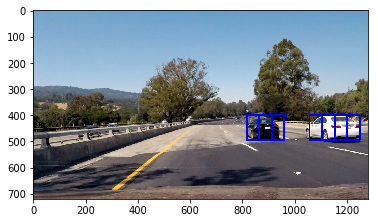

In [87]:
ystart = 400
ystop = 656
scale = 1.5
spatial_size = (32,32)
hist_bins = 32
img = mpimg.imread('test_image.jpg')
out_img = find_cars(img, colorspace, ystart, ystop, scale, classifier, None, orient, pix_per_cell, cell_per_block, spatial_size=(32,32), hist_bins=32)

plt.imshow(out_img)

Since we will allow some overlap in the sliding windows function, the above series of functions will almost certainly return multiple detections on the same car. Also, since our classifier isn't perfect, we will naturally get some false positives. Both of these need to be filtered out. The method to solve both at the same time is by using a heatmap. For an initially black image (set to 0), for every positive detection, the pixels within the detection window will be incremented. After any pixel below a given threshold will be set back to 0. As a result, only the locations with multiple detections will show a car.

In [12]:
def heat_threshold(heatmap, bbox_list, threshold):
    for box in bbox_list:
        
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0

    return heatmap

Finally, we need a function to draw bounding boxes around the detected vehicles. The input to this function is simply the heatmap and the original image. We will use a scipy function to label the distinct objects in the heatmap, and then draw boxes around those labelled locations onto the original image

In [13]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, heatmap):
    
    labels = label(heatmap)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Now that we have the entire functionality of the pipeline created, we ned to put it all together into one function that the moviepy editor can use to edit video frames.

In [14]:
def tracking_pipeline(image):
   
    # only search the bottom half of the image
    y_start_stop = [image.shape[0] * 0.5, image.shape[0]] # Min and max in y to search in slide_window()
    
    # first get the windows we want to feature extract and classify from
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    
    # determine which windows have a car in them
    hot_windows = search_windows(image, windows, classifier, scaler, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    
    # build a heatmap and threshold it
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = heat_threshold(heatmap, hot_windows, 3)
    
    # draw bounding boxes around the heatmap locations
    final = draw_labeled_bboxes(image, heatmap)
    
    return final

Before we waste time processing the video, let's test our pipeline on an image

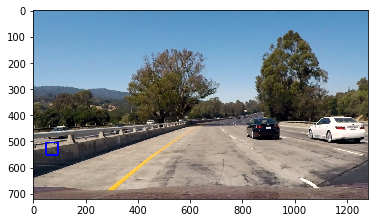

In [18]:
import matplotlib.pyplot as plt

test = mpimg.imread("./test_images/test1.jpg")
plt.imshow(test)

result = tracking_pipeline(test)
plt.imshow(result)

Then finally add the functionality to grab single frames from a video:

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'test_videos_output/result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip

clip1 = VideoFileClip("project_video.mp4").subclip(5,10)
clip = clip1.fl_image(tracking_pipeline) # NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/result.mp4
[MoviePy] Writing video test_videos_output/result.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [02:00<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/result.mp4 

Wall time: 2min 1s
